# Navigating Turbulent Odor Plumes Using Reinforcement Learning

This notebook uses the Q-learning algorithm of Reinforcement Learning (RL) to train virtual agents to navigate a 2D turbulent odor plume. Turbulent odor plumes are spatiotemporally complex: odor signals arrive in random, unpredictable bursts, and odor concentration does follow continuous gradients, making plume navigation a difficult task. Suprisingly, there has been no published work on applying RL algorithms to turbulent odor plume navigation. 

## Q-learning algorithm
Q-learning updates a state-action value function, $Q(a, s)$, which quantifies the value of taking action $a$ when in state $s$. This function is updated in time using the Q-learning algorithm. At each timestep, the navigator takes an action $A$ to go from state $S$ to state $S'$, using whatever policy (greedy, $\epsilon$-greedy, etc.), where it receives a reward $R$. Then $Q(A, S)$ is updated using a *greedy* update rule (hence *off-policy*):

$\begin{align}
 Q(A, S) \leftarrow Q(A, S) + \alpha[R + \gamma \max_a Q(a, S')  - Q(A, S)]
\end{align}$

Here, $\alpha < 1$ and $\gamma < 1$ are update step-size and learning rate -- both hyperparameters in the simulation.

### State space: $\{s\}$

Following results found recently for navigation of odor plumes by fruit flies, we assume that navigators rely on the frequency of odor hits. An odor hit is the time at which the signal surpassses a given threshold. Running average of hit frequency, $W_freq$, is found by convolving the binary time series of odor hit times $w(t)$ with an exponential kernel ($\tau = 2$ seconds):

$W_{freq} = \int^t_{-\infty} e^{-(t-t')/\tau} w(t')dt'$

We discretize the state space into low and high frequency,

$S_1$: $W_{freq} < \text{thresh}$

$S_2$: $W_{freq} >= \text{thresh}$

where $thresh$ is to be chosen

### Action space: $\{a\}$
The navigators move on a grid, and we assume that there are 4 actions:

$A_1$: turn upwind (i.e. left)
$A_2$: walk straight
$A_3$: turn randomly in one of the 4 directions
$A_4$: turn toward the plume centerline

The last action $A_4$ means that, in the plume cone, flies in the top half will turn downward, and flies in the bottom half will turn upward. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append('src')
from utils import gen_plot

In [2]:
# Step size
alpha = 0.9

# Learning rate
gamma = 0.9

In [202]:
class centerline_upwind(object):
    """
    TODO
    """
    
    def __init__(self):
        self.num_steps = 2000
        self.xy_step = 2
        self.seed = 1
        self.num_walkers = 500
        
        # Odor plume from video
        self.vid_file = r'data/intermittent_smoke.avi'
        self.beg_frm = 500
        
        # Actions
        self._num_actions = 4
        self.epsilon = 0.05
        
        # States are delineated by odor frequency
        # self.odors holds odors in recent past
        self.freq_bins = [-0.01, 3, 5, 7, 100]
        self._num_states = len(self.freq_bins) - 1
        self.odor_threshold = 100
        self.odors = np.zeros((300, self.num_walkers))

        # Q(s, a) for each walker
        self.Q = np.ones((self.num_steps, self._num_states, self._num_actions, self.num_walkers))
    
    def run(self):
        
        np.random.seed(self.seed)
        
        cap = cv2.VideoCapture(self.vid_file)
        cap.set(cv2.CAP_PROP_POS_FRAMES, self.beg_frm)
    
        xs = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        ys = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        vs = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        states = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        self.ends = np.zeros(self.num_walkers)
        self.path_lengths = np.ones(self.num_walkers)*self.num_steps
        
        xs[0] = np.random.randint(1000, 1150, self.num_walkers)
        ys[0] = np.random.randint(450 - 200, 450 + 200, self.num_walkers)
        vs[0] = np.ones(self.num_walkers)
        
        for iS in range(self.num_steps - 1):
            print (iS, end = " ", flush=True)
            
            # Binary array if action is optimal for that walker: (num_actions, num_walkers)
            last_Q = self.Q[iS, states[iS], :, np.arange(self.num_walkers)].T ## RIGHT???
            opt_action_arr = 1.*(last_Q == np.amax(last_Q, axis=0))
            
            # From the optimal actions, choose randomly by random shifts for `1'
            opt_action_arr *= np.random.normal(1, 0.01, opt_action_arr.shape)
            actions = np.argmax(opt_action_arr, axis=0)
            
            # Epsilon-greedy action selection
            actions_to_flip = np.random.uniform(0, 1, self.num_walkers) > (1. - self.epsilon)
            random_actions = np.random.randint(0, self._num_actions, self.num_walkers)
            actions[actions_to_flip] = random_actions[actions_to_flip]
            
            # Update position based on action
            _xs = xs[iS]
            _ys = ys[iS]

            _xs[_xs > 1500] = 1500
            _xs[_xs < 0] = 0
            _ys[_ys < 0] = 0
            _ys[_ys > 895] = 895
            
            _vs = np.empty(self.num_walkers)*np.nan
            _vs[actions == 0] = 2
            _vs[actions == 1] = vs[iS, actions == 1]
            _vs[actions == 2] = np.random.randint(0, 4, np.sum(actions == 2))
            _vs[actions == 3] = (ys[iS, actions == 3] > 450)*3 + (ys[iS, actions == 3] <= 450)*1
            
            _xs[_vs == 0] += self.xy_step
            _xs[_vs == 2] -= self.xy_step
            _ys[_vs == 1] += self.xy_step
            _ys[_vs == 3] -= self.xy_step
            
            xs[iS + 1] = _xs
            ys[iS + 1] = _ys
            vs[iS + 1] = _vs
            
            # Those that reached the source
            _ends = (xs[iS] < 150)*(abs(ys[iS] - 450) < 50)
            self.path_lengths[(self.ends == 0)*_ends] = iS
            self.ends[_ends] = 1
            
            if iS > 5000:
                cap = cv2.VideoCapture(vid_file)
                cap.set(cv2.CAP_PROP_POS_FRAMES, 500)
            ret, frm = cap.read()
            frm = frm[:, :, 2]
            whfs = 1.*(frm[(ys[iS], xs[iS])] > self.odor_threshold)
            
            # Update recent reward vector
            self.odors = np.roll(self.odors, -1, axis=0)
            self.odors[-1] = whfs
            
            # State is 1 if odor frequency is enough
            freq_mean = np.sum((np.diff(self.odors, axis=0) > 0).T*
                               np.exp(-np.arange(self.odors.shape[0] - 1).T/100)[::-1], axis=1) ## /100??
            new_state = np.digitize(freq_mean, self.freq_bins, right=True) - 1
            rewards = whfs 
            
            self.Q[iS + 1] = self.Q[iS]
            self.Q[iS + 1, states[iS], actions, np.arange(self.num_walkers)] = \
                self.Q[iS, states[iS], actions, np.arange(self.num_walkers)] + \
                alpha*(rewards + 
                       gamma*np.amax(self.Q[iS, new_state, :, np.arange(self.num_walkers)].T, axis=0) - \
                self.Q[iS, states[iS], actions, np.arange(self.num_walkers)])
            states[iS + 1] = new_state
            
        # Plot trajs and Qmatrix
        print (xs.shape)
        plt.scatter(xs, ys)
        plt.xlim(100, 1500)
        plt.ylim(450-200, 450+200)
        plt.show()
        Q_norm = np.zeros((self._num_states, self._num_actions))
        for iW in range(self.num_walkers):
            Q_norm += self.Q[int(self.path_lengths[iW]) - 1, :, :, iW]
        plt.imshow(Q_norm/self.num_walkers)
        plt.colorbar()
        plt.show()

        return self.Q, Q_norm

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 (2000, 500)


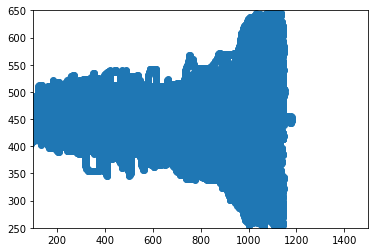

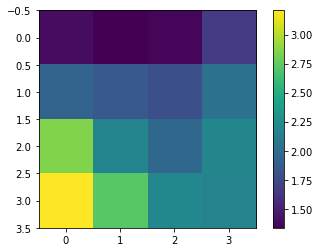

In [203]:
a = centerline_upwind()
Q, Q_norm = a.run()

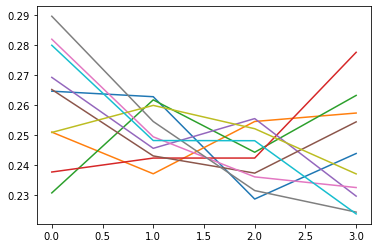

In [201]:
for i in range(10):
    plt.plot(Q_norm[i]/np.sum(Q_norm[i]))
plt.show()